In [36]:
import pandas as pd
import numpy as np
from scipy.stats import bootstrap
from sklearn.datasets import make_regression
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import resample
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(2)
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../Data/kc_final.csv', index_col = 0)

In [3]:
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,2015-01-16,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


# Preprocessing

In [4]:
df = df.drop_duplicates()
df.shape

(21613, 21)

In [5]:
df.id.nunique()

21436

In [6]:
del df['id']

In [7]:
df.isnull().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [8]:
labelencoder = LabelEncoder()
df['date'] = labelencoder.fit_transform(df['date'])
df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,164,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,220,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,290,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,220,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,283,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,19,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,288,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,52,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,252,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


# Correlation matrix

In [9]:
corr = df.loc[:, df.columns != 'price'].corr()
corr.style.background_gradient(cmap='coolwarm')

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
date,1.000000,-0.016964,-0.034481,-0.034570,0.006361,-0.022395,0.001544,-0.001837,-0.050755,-0.040040,-0.027890,-0.019554,-0.000471,-0.024401,0.001376,-0.032851,-0.007205,-0.031653,0.002643
bedrooms,-0.016964,1.000000,0.515884,0.576671,0.031703,0.175429,-0.006582,0.079532,0.028472,0.356967,0.477600,0.303093,0.154178,0.018841,-0.152668,-0.008931,0.129473,0.391638,0.029244
bathrooms,-0.034481,0.515884,1.000000,0.754665,0.087740,0.500653,0.063744,0.187737,-0.124982,0.664983,0.685342,0.283770,0.506019,0.050739,-0.203866,0.024573,0.223042,0.568634,0.087175
sqft_living,-0.034570,0.576671,0.754665,1.000000,0.172826,0.353949,0.103818,0.284611,-0.058753,0.762704,0.876597,0.435043,0.318049,0.055363,-0.199430,0.052529,0.240223,0.756420,0.183286
sqft_lot,0.006361,0.031703,0.087740,0.172826,1.000000,-0.005201,0.021604,0.074710,-0.008958,0.113621,0.183512,0.015286,0.053080,0.007644,-0.129574,-0.085683,0.229521,0.144608,0.718557
floors,-0.022395,0.175429,0.500653,0.353949,-0.005201,1.000000,0.023698,0.029444,-0.263768,0.458183,0.523885,-0.245705,0.489319,0.006338,-0.059121,0.049614,0.125419,0.279885,-0.011269
waterfront,0.001544,-0.006582,0.063744,0.103818,0.021604,0.023698,1.000000,0.401857,0.016653,0.082775,0.072075,0.080588,-0.026161,0.092885,0.030285,-0.014274,-0.041910,0.086463,0.030703
view,-0.001837,0.079532,0.187737,0.284611,0.074710,0.029444,0.401857,1.000000,0.045990,0.251321,0.167649,0.276947,-0.053440,0.103917,0.084827,0.006157,-0.078400,0.280439,0.072575
condition,-0.050755,0.028472,-0.124982,-0.058753,-0.008958,-0.263768,0.016653,0.045990,1.000000,-0.144674,-0.158214,0.174105,-0.361417,-0.060618,0.003026,-0.014941,-0.106500,-0.092824,-0.003406
grade,-0.040040,0.356967,0.664983,0.762704,0.113621,0.458183,0.082775,0.251321,-0.144674,1.000000,0.755923,0.168392,0.446963,0.014414,-0.184862,0.114084,0.198372,0.713202,0.119248


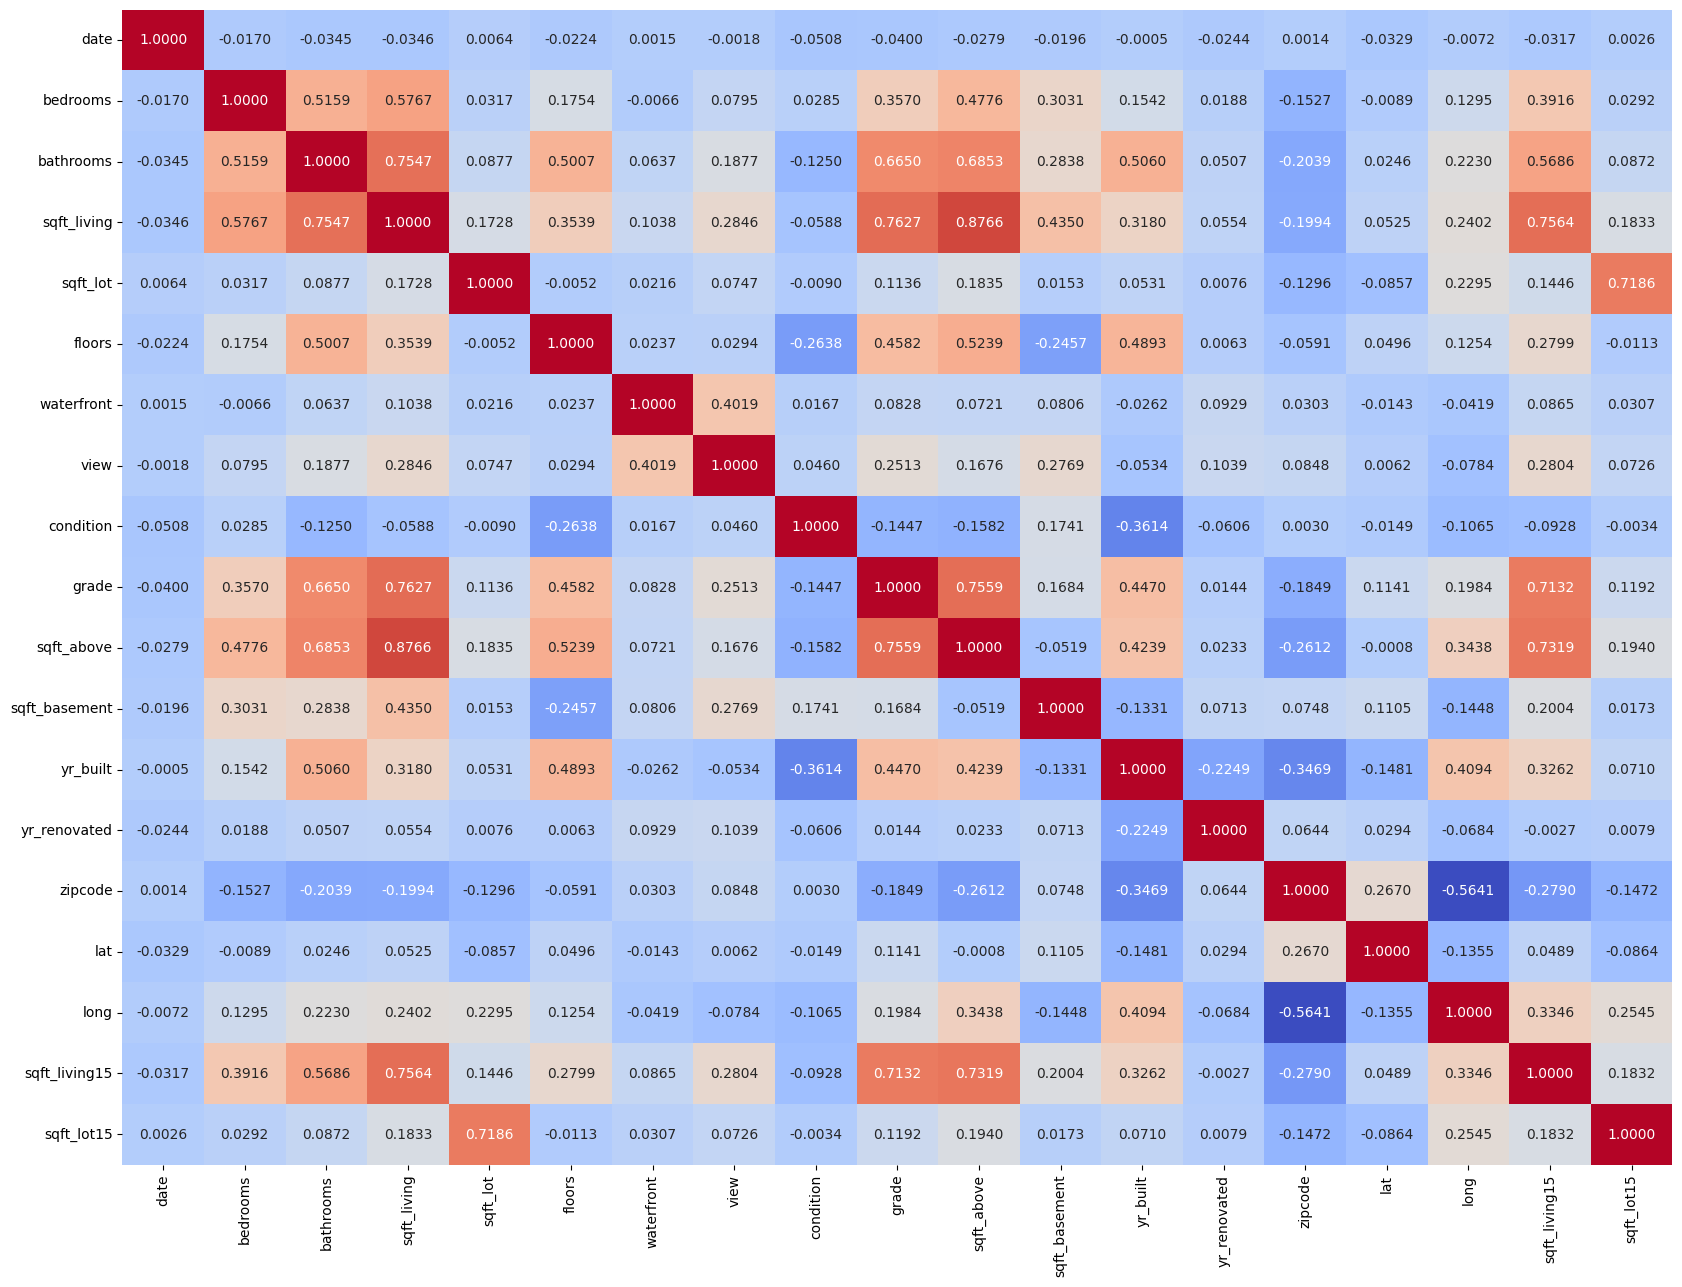

In [10]:
fig, ax = plt.subplots(figsize = (20, 15))
sns.heatmap(df.loc[:, df.columns != 'price'].corr(), annot=True, fmt='.4f', 
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
plt.savefig('result.png', bbox_inches='tight', pad_inches=0.0)

In [11]:
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [12]:
cor_matrix = df.loc[:, df.columns != 'price'].corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
print(to_drop)

['sqft_above']


In [13]:
# df1 = df.drop(columns = to_drop, axis=1)

In [14]:
df1 = df

In [15]:
zipcode = pd.get_dummies(df.zipcode, prefix='zipcode')
df1 = pd.concat([df1,zipcode], axis = 1)
del df1['zipcode']

In [16]:
X = df1.loc[:, df1.columns != 'price']
y = df1['price']

In [17]:
X

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,164,3,1.00,1180,5650,1.0,0,0,3,7,...,0,0,0,0,0,0,1,0,0,0
1,220,3,2.25,2570,7242,2.0,0,0,3,7,...,0,0,0,0,0,0,0,0,0,0
2,290,2,1.00,770,10000,1.0,0,0,3,6,...,0,0,0,0,0,0,0,0,0,0
3,220,4,3.00,1960,5000,1.0,0,0,5,7,...,0,0,0,0,0,0,0,0,0,0
4,283,3,2.00,1680,8080,1.0,0,0,3,8,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,19,3,2.50,1530,1131,3.0,0,0,3,8,...,0,0,0,0,0,0,0,0,0,0
21609,288,4,2.50,2310,5813,2.0,0,0,3,8,...,1,0,0,0,0,0,0,0,0,0
21610,52,2,0.75,1020,1350,2.0,0,0,3,7,...,0,0,0,0,0,0,0,0,0,0
21611,252,3,2.50,1600,2388,2.0,0,0,3,8,...,0,0,0,0,0,0,0,0,0,0


# Train-Test split, Scaling

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train_cols = X_train.columns

In [19]:
scaler = StandardScaler()
scaler.fit(X_train,y_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Building the model

In [20]:
lasso = Lasso()
lasso_fit = lasso.fit(X_train,y_train)

In [21]:
y_pred = lasso_fit.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,y_pred)))
print(np.sqrt(mean_absolute_error(y_test,y_pred)))

180406.39680695254
313.6604581108603


In [22]:
r2_score(y_test, y_pred)

0.7914627974187516

## Finding the best alpha using LassoCV

In [23]:
lasso_cv_model = LassoCV(alphas = np.random.randint(1,1000,100), cv = 10, max_iter = 100000).fit(X_train,y_train)

In [24]:
lasso_cv_model.alpha_

20

In [25]:
lasso_tuned = Lasso(alpha = lasso_cv_model.alpha_).fit(X_train,y_train)

y_pred_tuned = lasso_tuned.predict(X_test)

rmse_test = (np.sqrt(mean_squared_error(y_test,y_pred_tuned)))
mae_test = (np.sqrt(mean_absolute_error(y_test,y_pred_tuned)))
r2_test = (r2_score(y_test, y_pred_tuned))

In [26]:
#Test
result_table_test = pd.DataFrame(columns = ['Metric', 'Value'])
result_table_test.loc[0] = ['RMSE', rmse_test]
result_table_test.loc[1] = ['MAE', mae_test]
result_table_test.loc[2] = ['R2', r2_test]

print('Lasso Test metrics')
result_table_test

Lasso Test metrics


,Metric,Value
0,RMSE,180418.886333
1,MAE,313.652189
2,R2,0.791434


In [27]:
y_pred_train_tuned = lasso_tuned.predict(X_train)

rmse_train = (np.sqrt(mean_squared_error(y_train,y_pred_train_tuned)))
mae_train = (np.sqrt(mean_absolute_error(y_train,y_pred_train_tuned)))
r2_train = (r2_score(y_train, y_pred_train_tuned))

In [28]:
#Train
result_table_train = pd.DataFrame(columns = ['Metric', 'Value'])
result_table_train.loc[0] = ['RMSE', rmse_train]
result_table_train.loc[1] = ['MAE', mae_train]
result_table_train.loc[2] = ['R2', r2_train]

print('Lasso Train metrics')
result_table_train

Lasso Train metrics


,Metric,Value
0,RMSE,151235.932206
1,MAE,304.122222
2,R2,0.817940


## Analysing model coefficients

In [29]:
coef_df = pd.DataFrame(columns = ['columns', 'Lasso_coef'])
coef_df['columns'] = X_train_cols
coef_df['Lasso_coef'] = lasso_tuned.coef_
coef_df

,columns,Lasso_coef
0,date,12559.850172
1,bedrooms,-21924.140260
2,bathrooms,15189.734842
3,sqft_living,180848.975467
4,sqft_lot,8129.407269
...,...,...
83,zipcode_98177,6.652321
84,zipcode_98178,-12588.534923
85,zipcode_98188,-8916.226653
86,zipcode_98198,-15332.072181


In [30]:
coef_df[(coef_df['Lasso_coef']<50) & (coef_df['Lasso_coef']>-50)]

,columns,Lasso_coef
83,zipcode_98177,6.652321


In [31]:
coef_df[coef_df['columns'].isin(['sqft_above','sqft_living'])]

,columns,Lasso_coef
3,sqft_living,180848.975467
10,sqft_above,353.074953


In [32]:
coef_df[(coef_df['Lasso_coef']<0)]

,columns,Lasso_coef
1,bedrooms,-21924.140260
5,floors,-21588.424271
11,sqft_basement,-32727.702494
12,yr_built,-20834.679681
15,long,-18511.959308
17,sqft_lot15,-1717.800404
18,zipcode_98001,-14703.241863
19,zipcode_98002,-7724.632539
20,zipcode_98003,-15238.598472
26,zipcode_98010,-263.110145


# Cross Validation

In [33]:
k_folds = KFold(n_splits = 10)

scores = cross_val_score(lasso_tuned, X, y, cv = k_folds, scoring = 'r2')

print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())

Cross Validation Scores:  [0.79024002 0.80239119 0.80529852 0.77696371 0.79297241 0.81864429
 0.81811265 0.83593176 0.80650679 0.81784386]
Average CV Score:  0.8064905198486928


# Bootstrap

In [55]:
r2BS = []
nIterations = 1000
for i in range(nIterations):
    xBS, yBS = resample(X_train, y_train, replace=True)

    yPredBS = lasso_tuned.predict(xBS)

    score = r2_score(yBS, yPredBS)
    r2BS.append(score)

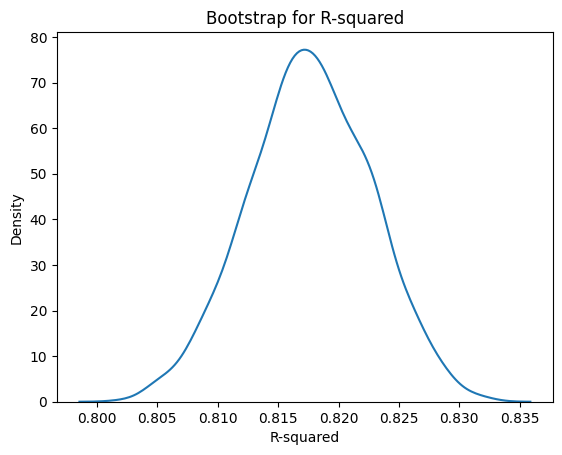

In [56]:
sns.kdeplot(r2BS)
plt.title("Bootstrap for R-squared")
plt.xlabel("R-squared")
plt.show()

In [57]:
median = np.percentile(r2BS, 50)

alpha = 100-95
lowerCI = np.percentile(r2BS, alpha/2)
upperCI = np.percentile(r2BS, 100-alpha/2)

print(f"Median r-squared is {median:.2f} with a 95% a confidence "
      f"interval of [{lowerCI:.2f},{upperCI:.2f}].")

Median r-squared is 0.82 with a 95% a confidence interval of [0.81,0.83].


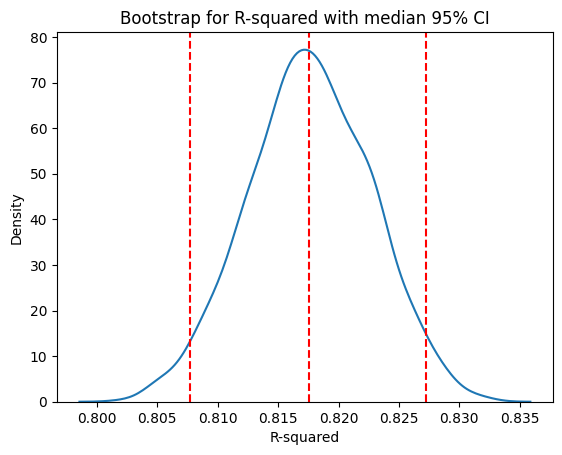

In [58]:
sns.kdeplot(r2BS)
plt.title("Bootstrap for R-squared with median 95% CI")
plt.xlabel("R-squared")
plt.axvline(median,0, 14, linestyle="--", color="red")
plt.axvline(lowerCI,0, 14, linestyle="--", color="red")
plt.axvline(upperCI,0, 14, linestyle="--", color="red")
plt.show()